# Optimal Hedged Monte Carlo

Author: Jerry Xia

Date: 2018/06/19

## 1 Introduction

This is a Python Notebook about variance reduction Monte Carlo simulations. In this script, I implemented the following variance reduction methods as well as their antithetic variates' version:

* regular Monte Carlo
* Monte Carlo with delta-based control variates
* optimal hedged Monte Carlo

Due to the significance and robustness, I mainly focus on the optimal hedged Monte Carlo (OHMC) in option pricing. We invoke this method to price European options and make comparison with other methods.

### 1.1 Facts
* The option price is not simply the average value of the discounted future pay-off over the objective (or historical) probability distribution
* The requirement of absence of arbitrage opportunities is equivalent to the existence of "risk-neutral measure", such that the price is indeed its average discounted future pay-off.
* Risk in option trading cannot be eliminated

### 1.2 Objective
* It would be satisfactory to have an option theory where the objective stochastic process of the underlying is used to calculate the option price, the hedge strategy and the *residual risk*.

### 1.3 Advantages
* It is a versatile methods to price complicated path-dependent options.
* Considerable variance reduction scheme for Monte Carlo
* It provide not only a numerical estimate of the option price, but also of the optimal hedge strategy and of the residual risk.
* This method does not rely on the notion of risk-neutral measure, and can be used to any model of the true dynamics of the underlying

## 2 Underlying dynamics

### Black-Scholes Model
$$dS = \mu S dt + \sigma S dW_t$$
$$log S_{t+1} = log S_t +(\mu - \frac{\sigma^2}{2})\Delta t + \sigma \sqrt{\Delta t} \epsilon$$
where
$$\epsilon \sim N(0,1)$$
In risk neutral measure, $\mu = r - q$. 
### Heston Model
The basic Heston model assumes that $S_t$, the price of the asset, is determined by a stochastic process:
$$
dS_t = \mu S_t dt + \sqrt{v_t} S_t d W_t^S\\
dv_t = \kappa (\theta - v_t) dt + \xi \sqrt{v_t} d W_t^v
$$
where 
$$E[dW_t^S,dW_t^v]=\rho dt$$
In risk neutral measure, $\mu = r - q$. 

## 3 Methodology

### 3.1 Notation
Option price always requires to work backward. That is because the option price is known exactly at the maturity. As with other schemes, we determine the option price step by step from the maturity $t=K\tau=T$ to the present time $t=0$. The unit of time being $\tau$, for example, one day. We simulate $N$ trajectories. In trajectory i, the price of the underlying asset at time $k\tau$ is denoted as $S_k^{(i)}$. The price of the derivative at time $k\tau$ is denoted as $C_k$, and the hedge function is $H_k$. We define an optimal hedged portfolio as
$$W_k^{(i)} = C_k(S_k^{(i)}) + H_k(S_k^{(i)})S_k^{(i)}$$
The one-step change of our portfolio is
$$\Delta W_k^{(i)}= df(k,k+1) C_{k+1}(S_{k+1}^{(i)}) - C_k(S_k^{(i)}) + H_k(S_{k}^{(i)}) (df2(k,k+1) S_{k+1}^{(i)} - S_{k}^{(i)})$$
Where $df(k,k+1)$ is the discounted factor from time $k\tau$ to $(k+1) \tau$, $df2(k,k+1)$ is the discounted factor considering dividend $e^{-(r-q)(t_{k+1}-t_k)}$

### 3.2 Objective
The optimal hedged algorithm can be interpreted as the following optimal problem

\begin{align}
\mbox{minimize}\quad & \quad Var[\Delta W_k]\\
\mbox{subject to}\quad & \quad E[\Delta W_k]=0
\end{align}

It means we should try to minimize the realized volatility of hedged portfolio while maintaining the expected value of portfolio unchanged.

### 3.3 Basis Functions
The original optimization is very difficult to solve. Thus we assume a set of basis function and solved it in such subspace. We use $N_C$and $N_H$ to denote the number of basis functions for price and hedge.

\begin{align}
C_k(\cdot) &= \sum_{i=0}^{N_C} a_{k,i} A_i(\cdot)\\
H_k(\cdot) &= \sum_{i=0}^{N_H} b_{k,i} B_i(\cdot)
\end{align}

The basis functions $A_i$ and $B_i$ are priori determined and need not to be identical. The coefficients $a_i$ and $b_i$ can be calibrated by solving the optimal problem.

### 3.4 Numerical Solution

\begin{align}
\mbox{minimize}\quad & \quad \frac{1}{N} \sum_{i=1}^N \Delta W_k^{(i)2}\\
\mbox{subject to}\quad & \quad \frac{1}{N} \sum_{i=1}^N \Delta W_k^{(i)}=0
\end{align}

Denote the discounted forward underlying price change at time $k\tau$ as

$$\Delta S_k = df2(k,k+1) S_{k+1} - S_k$$

Define

\begin{align}
Q_k &= \begin{bmatrix}
    -A_{k,1}(S_k^{(1)}) & \cdots & -A_{k,N_C}(S_k^{(1)}) & B_{k,1}(S_k^{(1)})\Delta S_k^{(1)}& \cdots  & B_{k,N_H}(S_k^{(1)})\Delta S_k^{(1)} \\
    -A_{k,1}(S_k^{(2)}) & \cdots & -A_{k,N_C}(S_k^{(2)}) & B_{k,1}(S_k^{(2)})\Delta S_k^{(2)}& \cdots  & B_{k,N_H}(S_k^{(1)})\Delta S_k^{(2)} \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    -A_{k,1}(S_k^{(N)}) & \cdots & -A_{k,N_C}(S_k^{(N)}) & B_{k,1}(S_k^{(N)})\Delta S_k^{(N)}& \cdots  & B_{k,N_H}(S_k^{(N)})\Delta S_k^{(N)}
    \end{bmatrix}\\\\
c_k &= (a_{k,1}, \cdots a_{k,N_C}, b_{k,1}, \cdots, b_{k,N_H})^T\\\\
v_{k} &= df(k,k+1) C_{k+1}(S_{k+1}^{})
\end{align}

As for $v_k$, note that we know the exact value at maturity, which means there is no need to approximate price in terms of basis functions, that is

\begin{align}
v_k = \begin{cases}
df(N-1,N)\ payoff(S_N),\quad & k=N-1\\
df(k,k+1)\ \sum_{i=1}^{N_C} a_{k+1,i} A_i(S_{k+1}), \quad & 0<k<N-1\\
df(0,1)\ C_1(S_1), \quad & k=0
\end{cases}
\end{align}

Then, the optimization problem can be expressed as

\begin{align}
\arg\min_{c_k}\quad & \quad (v_{k} + Q_k c_k)^T (v_{k} + Q_k c_k)\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T (v_{k}  + Q_k c_k)=0
\end{align}

In step k, since we already know the information ($v_{k}$) in step k+1. By canceling the constant term, the optimal problem can be simplified as the following 

\begin{align}
\arg\min_{c_k}\quad & \quad 2 v_{k}^T Q_k c_k + c_k^T Q_k^T Q_k c_k\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T v_{k}  + 1_{[N\times1]}^T Q_k c_k=0
\end{align}

### 3.5 Convex Optimization Problem

Let us first review the standard form of linear constrained quadratic programming problem:

\begin{align}
    \min_{x} \quad & \frac{1}{2} x^T P x + q^T x\\
    \mbox{subject to} \quad &G x \preceq h\\
    &A x = b
\end{align}

Note that $x^T$ means the transpose of vector x, and $G x \preceq h$denotes the inequality is taken element-wise over the vectors $G x$ and $h$. The objective function is convex if and only if the matrix $P$ is positive-semidefinite(Hermitian matrix all of whose eigenvalues are nonnegative), which is the realm we concern with.

Recall that the constrained optimization problem:

\begin{align}
\arg\min_{c_k}\quad & \quad  v_{k}^T Q_k c_k + \frac{1}{2}c_k^T Q_k^T Q_k c_k\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T v_{k}  + 1_{[N\times1]}^T Q_k c_k=0
\end{align}

Correspondingly, we make the connection by letting

\begin{align}
    x &= c_k\\
    P &= Q_k^T Q_k\\
    q &= Q_k^T v_k\\
    A &= 1_{[N\times1]}^T Q_k\\
    b &= -1_{[N\times1]}^T v_{k}
\end{align}

The hard work is almost over right now. As you would always find, formulating the problem is usually the hard step. Invoking a solver is straightforward.

Note that when $k=0$, the degree of freedom of the quadratic problem decreases to 2. Because here the only concerns are price and hedge at time zero (we don't need to project them into a high dimension space). Let $x=[C_0, H_0]^T$

\begin{align}
    Q_0 &= \begin{bmatrix}
    -1 & \Delta S_0^{(1)}\\
    \vdots & \vdots\\
    -1 & \Delta S_0^{(N)}
    \end{bmatrix}\\
    P &= Q_0^T Q_0\\
    q &= Q_0^T v_0\\
    A &= 1_{[N \times 1]}^T Q_0\\
    b &= -1_{[N \times 1]}^T v_0
\end{align}

## 4 Variance reduction and other methods
The rate of convergence of the Monte Carlo simulation is $O\left(\max \left( \Delta t, \frac{1}{N_x} \right)\right)$. The variance reduction techniques are used to reduce the constant factor corresponding to the Monte Carlo approximation $O \left(\frac{1}{N_x}\right)$. Some of the most used variance reduction techniques are:

* Control Variates
* Antithetic Variates
* Moment Matching

In this part we selected antithetic variates and delta-based control variates methods as a supplement to optimal hedged monte carlo simulation.

### 4.1 Antithetic variates
The main idea of this technique is to look at the asset equation that you aretrying to simulate:
$$d S_t^{(1)} = r S_t^{(1)} dt + \sigma S_t^{(1)} d W_t$$
and recognize that sinceztis a standard Brownian motion so will be−ztandthey will have the same exact distribution.  This means that the equation:
$$d S_t^{(2)} = r S_t^{(2)} dt - \sigma S_t^{(2)} d W_t$$
will also generate paths of the same asset.
The variance depends on the sign of the covariance of $payoff(S_t^{(1)})$ and $payoff(S_t^{(2)})$. It can increase the eventual variance or decrease it, both case do arise. One sufficient condition to insure variance reduction is the monotony of the payoff function. Then, when using both in the calculation of the final Monte Carlo value the variance of the estimate will be reduced.

### 4.2 Delta-based control variates
Delta hedging can be summarized succinctly in the following way:  Suppose that at time $t= 0$, we receive $C_0$ the price of an option that pays $C_T$ at time T.  The price of this option at any time $t$ is a function $C(t,S)$. Then, if we hold at any moment in time $\frac{\partial C}{\partial S}(t,S) = \frac{\partial C_t}{\partial S}$ units of stock, then we will be able to replicate the payout of this option $C_T$ at time T. This is in theory since of course we cannot trade continuously. So in practice we perform a partial hedge where we only rebalance at some discrete moments in time say $t_1,t_2,\cdots,t_N$. The replicating strategy can be expressed as follow:
$$W(t_i,S_i) = C(t_0,S_0) e^{r(t_i - t_0)} + \sum_{j=0}^{i} \Delta(t_j,S_j) ( S_{j+1} e^{-r(t_{j+1} - t_j )} - S_{j})e^{r(t_i - t_j)} = C(t_i,S_i)$$
which is similar to the strategy in the optimal hedged Monte Carlo simulation where the only difference is that in OHMC, we use option and delta hedging to replicate the cash flow and here we do the opposite operation. But when implementing the delta-based control variates, we should move the hedging term to the right hand side which make it identical to the OHMC strategy. Note that here we are assumed to know the delta hedging function. It explains a lot why OHMC can reduce the variance.

### 4.3 Optimal hedged Monte Carlo simulation
**In conclusion, OHMC is just a control variates method with an optimization on top and it is more practical because we do not have an analytical formula for the hedge sensitivity (i.e. delta, gamma, etc.)**

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
from cvxopt import matrix, solvers
import pandas as pd

In [2]:
risk_free_rate = 0.0319
dividend = 0
time_to_maturity = 1
volatility = 0.2
strike = 100
stock_price = 100
V0 = 0.010201
kappa = 6.21
theta = 0.019
xi = 0.61
rho = -0.7

n_trials = 1000
n_steps = 200
func_list = [lambda x: x**0, lambda x: x]

In [3]:
from MonteCarlo import MonteCarlo   
      

In [4]:
mc = MonteCarlo(S0=stock_price,K=strike,T=time_to_maturity,r=risk_free_rate,q=dividend,sigma=volatility,
                kappa=kappa,theta=theta,xi=xi,rho=rho,V0=V0,underlying_process="Heston model")


In [5]:
price_matrix = mc.simulate(n_trials=n_trials,n_steps=n_steps,boundaryScheme="Higham and Mao")

In [6]:
mc.MCPricer()

7.4286345152762516

In [7]:
mc.BSDeltaHedgedPricer()

7.0048861512919327

In [8]:
mc.OHMCPricer()

7.233493440650192

In [9]:
prices = mc.pricing(func_list=func_list)
print(prices)

{'OHMC': 7.233493440650192, 'regular MC': 7.4286345152762516, 'Black-Scholes': 9.5095295701347027}


In [10]:
hedges = mc.hedging()
print(hedges)

{'OHMC optimal hedge': 0.5077634149472071, 'Black-Scholes delta hedge': 0.60237525898994781, 'OHMC residual risk': array([ -2.91038305e-14])}


## 4 Methods Comparison

In this part, we discuss the performance of OHMC and regular MC. The underlying stochastic process is Heston model. In the following, we compare the absolute error with respect to the Black-Scholes price corresponding to trajactories number and runtime. The result is displayed by scatter plots.

In [11]:
import timeit

In [12]:
def performance_comparison(n_trials,n_steps,underlying_process="geometric brownian motion"):
    if(underlying_process=="geometric brownian motion"):
        mc = MonteCarlo(stock_price,strike,time_to_maturity,risk_free_rate,dividend,volatility)
        theoretical_value = mc.BlackScholesPricer()
    elif(underlying_process=="Heston model"):
        mc = MonteCarlo(S0=stock_price,K=strike,T=time_to_maturity,r=risk_free_rate,q=dividend,sigma=volatility,
                kappa=kappa,theta=theta,xi=xi,rho=rho,V0=V0,underlying_process="Heston model")
        theoretical_value = 6.8061
    
    # black scholes
    bs_start = timeit.default_timer()
    bs_price = mc.BlackScholesPricer('c')
    bs_sde_estimate = 'NA'
    bs_rmse = 'NA'
    bs_end = timeit.default_timer()
    
    # regular MC
    rmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    rmc_price = mc.MCPricer('c')
    rmc_sde_estimate = mc.standard_error()
    rmc_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    rmc_end = timeit.default_timer()
    
    # regular MC with antithetic variates
    rmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    rmc_anti_price = mc.MCPricer('c')
    rmc_anti_sde_estimate = mc.standard_error()
    rmc_anti_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    rmc_anti_end = timeit.default_timer()
    
    # Delta-based MC
    dbmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    dbmc_price = mc.BSDeltaHedgedPricer('c')
    dbmc_sde_estimate = mc.standard_error()
    dbmc_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    dbmc_end = timeit.default_timer()
    
    # Delta-based MC with antithetic variates
    dbmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps)
    dbmc_anti_price = mc.BSDeltaHedgedPricer('c')
    dbmc_anti_sde_estimate = mc.standard_error()
    dbmc_anti_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    dbmc_anti_end = timeit.default_timer()
    
    # OHMC
    ohmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    ohmc_price = mc.OHMCPricer('c')
    ohmc_sde_estimate = "NA"
    ohmc_rmse = 'NA'
    ohmc_end = timeit.default_timer()
    
    # OHMC with antithetic varietes
    ohmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    ohmc_anti_price = mc.OHMCPricer('c')
    ohmc_anti_sde_estimate = "NA"
    ohmc_anti_rmse = 'NA'
    ohmc_anti_end = timeit.default_timer()
    
    bs_runtime = bs_end - bs_start
    rmc_runtime = rmc_end - rmc_start
    dbmc_runtime = dbmc_end - dbmc_start
    ohmc_runtime = ohmc_end-ohmc_start
    rmc_anti_runtime = rmc_anti_end - rmc_anti_start
    dbmc_anti_runtime = dbmc_anti_end - dbmc_anti_start
    ohmc_anti_runtime = ohmc_anti_end-ohmc_anti_start
    
    bs_err = np.abs(bs_price - theoretical_value)
    rmc_err = np.abs(rmc_price - theoretical_value)
    dbmc_err = np.abs(dbmc_price - theoretical_value)
    ohmc_err = np.abs(ohmc_price - theoretical_value)
    rmc_anti_err = np.abs(rmc_anti_price - theoretical_value)
    dbmc_anti_err = np.abs(dbmc_anti_price - theoretical_value)
    ohmc_anti_err = np.abs(ohmc_anti_price - theoretical_value)
    
    
    result = {"method":["Black Scholes","MC","antithetic MC","DBMC","antithetic DBMC","OHMC","antithetic OHMC"],
              "runtime":[bs_runtime,rmc_runtime,rmc_anti_runtime,dbmc_runtime,dbmc_anti_runtime,
                         ohmc_runtime,ohmc_anti_runtime],
              "err":[bs_err,rmc_err,rmc_anti_err,dbmc_err,dbmc_anti_err,ohmc_err,ohmc_anti_err], 
              "standard err estimate":[bs_sde_estimate,rmc_sde_estimate,rmc_anti_sde_estimate,dbmc_sde_estimate,
                              dbmc_anti_sde_estimate,ohmc_sde_estimate,ohmc_anti_sde_estimate],
              "root mean square error":[bs_rmse, rmc_rmse, rmc_anti_rmse, dbmc_rmse, dbmc_anti_rmse, ohmc_rmse, ohmc_anti_rmse],
              "n_trials":[n_trials]*7,
              "n_steps":[n_steps]*7}
    return result

In [13]:
n_trials_list = np.arange(100,1000,500)
n_steps_list = np.arange(50,200,50)
performance_df = pd.DataFrame()
for n_trials in n_trials_list:
    for n_steps in n_steps_list:
        print("n_trials: {}; n_steps: {}".format(n_trials,n_steps))
        new_df = pd.DataFrame(performance_comparison(n_trials,n_steps,underlying_process="Heston model"))
        performance_df = pd.concat((performance_df,new_df))

n_trials: 100; n_steps: 50
n_trials: 100; n_steps: 100
n_trials: 100; n_steps: 150
n_trials: 600; n_steps: 50
n_trials: 600; n_steps: 100
n_trials: 600; n_steps: 150


In [14]:
sorted_efficiency_df = performance_df.set_index(['method','n_steps','n_trials']).sort_index()
sorted_efficiency_df

err root mean square error    runtime  \
method          n_steps n_trials                                               
Black Scholes   50      100       2.703430                     NA   0.000480   
                        600       2.703430                     NA   0.000324   
                100     100       2.703430                     NA   0.000346   
                        600       2.703430                     NA   0.000333   
                150     100       2.703430                     NA   0.000431   
                        600       2.703430                     NA   0.000645   
DBMC            50      100       0.548824                1.60789   0.607866   
                        600       0.422655                1.53969   2.692323   
                100     100       0.551444                1.38492   1.319747   
                        600       0.384824                 1.4216   5.705039   
                150     100       0.024386                1.24228   1.670167   
                        600       0.204089                1.44522  12.626791   
MC              50      100       1.089855                8.18064   0.023478   
                        600       0.438077                8.80041   0.007731   
                100     100       0.109861                7.34121   0.004958   
                        600       0.665718                8.43635   0.014241   
                150     100       0.048388                8.21575   0.007147   
                        600       0.422223                 8.1912   0.047758   
OHMC            50      100       0.902040                     NA   0.015391   
                        600       0.639134                     NA   0.021909   
                100     100       0.032222                     NA   0.040364   
                        600       0.475584                     NA   0.078652   
                150     100       0.492817                     NA   0.044626   
                        600       0.032711                     NA   0.086919   
antithetic DBMC 50      100       0.402666                1.78885   0.273746   
                        600       0.410585                1.51329   1.336698   
                100     100       0.635056                1.30191   0.649386   
                        600       0.249550                1.40571   4.248047   
                150     100       0.012359                1.18782   0.727217   
                        600       0.187533                1.37166   5.073001   
antithetic MC   50      100       0.562670                11.4092   0.002589   
                        600       0.308745                11.6998   0.005625   
                100     100       0.391531                10.0882   0.004393   
                        600       0.032050                 9.8583   0.010187   
                150     100       1.626620                18.4021   0.006634   
                        600       0.664989                8.67813   0.031840   
antithetic OHMC 50      100       1.194824                     NA   0.015838   
                        600       0.389528                     NA   0.022475   
                100     100       0.736264                     NA   0.041542   
                        600       0.339304                     NA   0.102591   
                150     100       0.518802                     NA   0.044841   
                        600       0.300874                     NA   0.078421   

                                 standard err estimate  
method          n_steps n_trials                        
Black Scholes   50      100                         NA  
                        600                         NA  
                100     100                         NA  
                        600                         NA  
                150     100                         NA  
                        600                         NA  
DBMC            50      100                   0.151893  
     

### 4.1 Variance Reduction Test

In thie section, we test more case and visualize the empirical error. Note that we do not concern Delta-based MC simulation since we cannot convert it to a matrix form, as a result, the method involes for-loop which is not efficient (see the form above). Moreover, the hypothesis which we know the delta hedge function is not realistic in practice. The result shows as follows.

In [15]:
def performance_comparison2(n_trials,n_steps,underlying_process="geometric brownian motion"):
    if(underlying_process=="geometric brownian motion"):
        mc = MonteCarlo(stock_price,strike,time_to_maturity,risk_free_rate,dividend,volatility)
        theoretical_value = mc.BlackScholesPricer()
    elif(underlying_process=="Heston model"):
        mc = MonteCarlo(S0=stock_price,K=strike,T=time_to_maturity,r=risk_free_rate,q=dividend,sigma=volatility,
                kappa=kappa,theta=theta,xi=xi,rho=rho,V0=V0,underlying_process="Heston model")
        theoretical_value = 6.8061
    
    # black scholes
    bs_start = timeit.default_timer()
    bs_price = mc.BlackScholesPricer('c')
    bs_sde_estimate = 'NA'
    bs_rmse = 'NA'
    bs_end = timeit.default_timer()
    
    # regular MC
    rmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    rmc_price = mc.MCPricer('c')
    rmc_sde_estimate = mc.standard_error()
    rmc_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    rmc_end = timeit.default_timer()
    
    # regular MC with antithetic variates
    rmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    rmc_anti_price = mc.MCPricer('c')
    rmc_anti_sde_estimate = mc.standard_error()
    rmc_anti_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
    rmc_anti_end = timeit.default_timer()
    
    # OHMC
    ohmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    ohmc_price = mc.OHMCPricer('c')
    ohmc_sde_estimate = "NA"
    ohmc_rmse = 'NA'
    ohmc_end = timeit.default_timer()
    
    # OHMC with antithetic varietes
    ohmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    ohmc_anti_price = mc.OHMCPricer('c')
    ohmc_anti_sde_estimate = "NA"
    ohmc_anti_rmse = 'NA'
    ohmc_anti_end = timeit.default_timer()
    
    bs_runtime = bs_end - bs_start
    rmc_runtime = rmc_end - rmc_start
    
    ohmc_runtime = ohmc_end-ohmc_start
    rmc_anti_runtime = rmc_anti_end - rmc_anti_start
    
    ohmc_anti_runtime = ohmc_anti_end-ohmc_anti_start
    
    bs_err = np.abs(bs_price - theoretical_value)
    rmc_err = np.abs(rmc_price - theoretical_value)
    
    ohmc_err = np.abs(ohmc_price - theoretical_value)
    rmc_anti_err = np.abs(rmc_anti_price - theoretical_value)
    
    ohmc_anti_err = np.abs(ohmc_anti_price - theoretical_value)
    
    
    result = {"method":["Black Scholes","MC","antithetic MC","OHMC","antithetic OHMC"],
              "runtime":[bs_runtime,rmc_runtime,rmc_anti_runtime,
                         ohmc_runtime,ohmc_anti_runtime],
              "err":[bs_err,rmc_err,rmc_anti_err,ohmc_err,ohmc_anti_err], 
              "standard err estimate":[bs_sde_estimate,rmc_sde_estimate,rmc_anti_sde_estimate,
                                       ohmc_sde_estimate,ohmc_anti_sde_estimate],
              "root mean square error":[bs_rmse, rmc_rmse, rmc_anti_rmse, ohmc_rmse, ohmc_anti_rmse],
              "n_trials":[n_trials]*5,
              "n_steps":[n_steps]*5}
    return result

In [16]:
n_trials_list = np.arange(100,10000,500)
# n_steps_list = np.arange(50,200,50)
performance_df2 = pd.DataFrame()
for n_trials in n_trials_list:
#     for n_steps in n_steps_list:
    print("n_trials: {}; n_steps: {}".format(n_trials,n_steps))
    new_df = pd.DataFrame(performance_comparison2(n_trials,n_steps,underlying_process="Heston model"))
    performance_df2 = pd.concat((performance_df2,new_df))

n_trials: 100; n_steps: 150
n_trials: 600; n_steps: 150
n_trials: 1100; n_steps: 150
n_trials: 1600; n_steps: 150
n_trials: 2100; n_steps: 150
n_trials: 2600; n_steps: 150
n_trials: 3100; n_steps: 150
n_trials: 3600; n_steps: 150
n_trials: 4100; n_steps: 150
n_trials: 4600; n_steps: 150
n_trials: 5100; n_steps: 150
n_trials: 5600; n_steps: 150
n_trials: 6100; n_steps: 150
n_trials: 6600; n_steps: 150
n_trials: 7100; n_steps: 150
n_trials: 7600; n_steps: 150
n_trials: 8100; n_steps: 150
n_trials: 8600; n_steps: 150
n_trials: 9100; n_steps: 150
n_trials: 9600; n_steps: 150


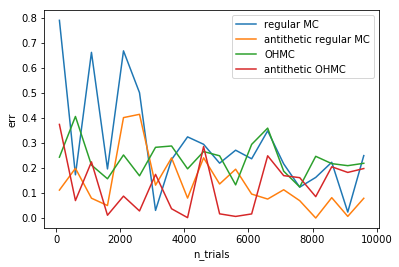

In [17]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

mc_trails = performance_df2[performance_df2["method"]=="MC"]["n_trials"]
mc_err = performance_df2[performance_df2["method"]=="MC"]["err"]
ax.plot(mc_trails,mc_err,label="regular MC")

anti_mc_trails = performance_df2[performance_df2["method"]=="antithetic MC"]["n_trials"]
anti_mc_err = performance_df2[performance_df2["method"]=="antithetic MC"]["err"]
ax.plot(anti_mc_trails,anti_mc_err,label="antithetic regular MC")

ohmc_trails = performance_df2[performance_df2["method"]=="OHMC"]["n_trials"]
ohmc_err = performance_df2[performance_df2["method"]=="OHMC"]["err"]
ax.plot(ohmc_trails,ohmc_err,label="OHMC")

anti_ohmc_trails = performance_df2[performance_df2["method"]=="antithetic OHMC"]["n_trials"]
anti_ohmc_err = performance_df2[performance_df2["method"]=="antithetic OHMC"]["err"]
ax.plot(anti_ohmc_trails,anti_ohmc_err,label="antithetic OHMC")

ax.legend()
plt.xlabel("n_trials")
plt.ylabel("err")

plt.show()

### 4.2 Runtime Efficiency Test

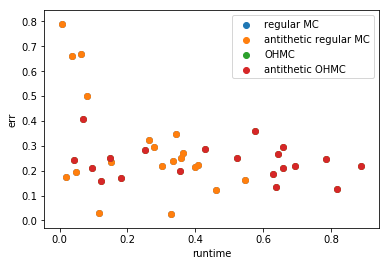

In [18]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

mc_runtime = performance_df2[performance_df2["method"]=="MC"]["runtime"]
mc_err = performance_df2[performance_df2["method"]=="MC"]["err"]
ax.scatter(mc_runtime,mc_err,label="regular MC")

anti_mc_runtime = performance_df2[performance_df2["method"]=="antithetic MC"]["runtime"]
anti_mc_err = performance_df2[performance_df2["method"]=="antithetic MC"]["err"]
ax.scatter(mc_runtime,mc_err,label="antithetic regular MC")

ohmc_runtime = performance_df2[performance_df2["method"]=="OHMC"]["runtime"]
ohmc_err = performance_df2[performance_df2["method"]=="OHMC"]["err"]
ax.scatter(ohmc_runtime,ohmc_err,label="OHMC")

anti_ohmc_runtime = performance_df2[performance_df2["method"]=="antithetic OHMC"]["runtime"]
anti_ohmc_err = performance_df2[performance_df2["method"]=="antithetic OHMC"]["err"]
ax.scatter(ohmc_runtime,ohmc_err,label="antithetic OHMC")

ax.legend()
plt.xlabel("runtime")
plt.ylabel("err")

plt.show()

### 4.4 Conclusion

From the test, one can see OHMC reduce the variance considerably, which make it more appreciable when number of trails is limited. For example, if we can only make trails less than 1000, OHMC is definite better than regular MC. However the runtime efficiency is similar based our observation. It seems slightly stable than regular MC, but still not enough to affirm that. As for the antithetic variates' version, there is no promotion in time efficiency and the variance reduction effect is valid only when number of trajectories is small enough and not gauranteed. Therefore, the antithetic variates method is not effective enough, the delta-based method is neither time efficient nor practical. At last, we highly recommand the optimal hedged Monte Carlo simulation as it is efficient, accurate and compatible to most of the stochastic process.

## 5 Boundary Scheme Test

Five kinds of boundary scheme:

* absorption
* reflection
* Higham and Mao
* partial truncation
* full truncation

We used Euler discretization schemes as presented in Table 1 of the paper 

Lord, Roger, Remmert Koekkoek, and Dick Van Dijk. A comparison of biased simulation schemes for stochastic volatility models. Quantitative Finance 10.2 (2010): 177-194.

https://www.ssoar.info/ssoar/bitstream/handle/document/22127/ssoar-2010-02-lord_et_al-a_comparison_of_biased_simulation.pdf?sequence=1

In [19]:
def boundary_scheme_comparison(n_trials,n_steps,boundarySchemes):
    simulation_start = timeit.default_timer()
    mc = MonteCarlo(S0=stock_price,K=strike,T=time_to_maturity,r=risk_free_rate,q=dividend,sigma=volatility,
                kappa=kappa,theta=theta,xi=xi,rho=rho,V0=V0,underlying_process="Heston model")
    simulation_end = timeit.default_timer()
    theoretical_value = 6.8061
    
    se_estimate_list = []
    rmse_list = []
    abs_err_list = []
    runtime_list = []
    
    for boundaryScheme in boundarySchemes:
        # regular MC
        rmc_start = timeit.default_timer()
        mc.simulate(n_trials,n_steps,boundaryScheme=boundaryScheme)
        rmc_price = mc.MCPricer('c')
        rmc_end = timeit.default_timer()
        
        rmc_se_estimate = mc.standard_error()
        rmc_rmse = np.sqrt(np.mean((mc.value_results - theoretical_value)**2))
        rmc_runtime = rmc_end-rmc_start + simulation_end - simulation_start
        rmc_err = np.abs(rmc_price - theoretical_value)
        se_estimate_list.append(rmc_se_estimate)
        rmse_list.append(rmc_rmse)
        abs_err_list.append(rmc_err)
        runtime_list.append(rmc_runtime)
        
    result = {"boundary scheme": boundarySchemes,
              "n_trials": [n_trials]*len(boundarySchemes),
              "n_steps": [n_steps]*len(boundarySchemes),
              "runtime": runtime_list,
              "abs err": abs_err_list,
              "root mean square err": rmse_list,
              "standard err estimate": se_estimate_list
             }
    return result

In [20]:
n_trials_list = np.arange(100,1000,500)
n_steps_list = np.arange(50,200,50)
boundarySchemes = ["absorption", "reflection", "Higham and Mao", "partial truncation", "full truncation"]
boundary_scheme_df = pd.DataFrame()
for n_trials in n_trials_list:
    for n_steps in n_steps_list:
        print("n_trials: {}; n_steps: {}".format(n_trials,n_steps))
        new_df = pd.DataFrame(boundary_scheme_comparison(n_trials,n_steps,boundarySchemes))
        boundary_scheme_df = pd.concat((boundary_scheme_df,new_df))

n_trials: 100; n_steps: 50
n_trials: 100; n_steps: 100
n_trials: 100; n_steps: 150
n_trials: 600; n_steps: 50
n_trials: 600; n_steps: 100
n_trials: 600; n_steps: 150


In [21]:
sorted_boundary_scheme_df = boundary_scheme_df.set_index(['boundary scheme','n_steps','n_trials']).sort_index()
sorted_boundary_scheme_df

abs err  root mean square err   runtime  \
boundary scheme    n_steps n_trials                                             
Higham and Mao     50      100       0.486407              8.224467  0.004541   
                           600       0.315152              7.818877  0.006758   
                   100     100       0.527316              8.275765  0.004912   
                           600       0.429531              8.367403  0.014096   
                   150     100       1.570269              8.525049  0.007029   
                           600       0.388945              7.282411  0.021307   
absorption         50      100       0.756648              8.064365  0.007919   
                           600       0.094931              7.756724  0.012094   
                   100     100       1.206100              8.070553  0.006275   
                           600       0.186890              7.652998  0.021262   
                   150     100       0.678147              7.121772  0.009942   
                           600       0.580559              8.236398  0.025793   
full truncation    50      100       0.344331              7.646292  0.005200   
                           600       0.617695              8.117524  0.007140   
                   100     100       1.490339              7.788039  0.004902   
                           600       0.569383              7.878562  0.014538   
                   150     100       0.089846              7.374268  0.008343   
                           600       0.036406              7.561167  0.021863   
partial truncation 50      100       0.774601              7.282134  0.005450   
                           600       0.412367              7.321595  0.007170   
                   100     100       0.001891              8.496781  0.004603   
                           600       0.046981              7.703554  0.016748   
                   150     100       0.865988              8.340313  0.007377   
                           600       0.192895              8.065819  0.021324   
reflection         50      100       0.040811              7.655841  0.005360   
                           600       0.746866              8.913519  0.009944   
                   100     100       0.343496              9.255441  0.004634   
                           600       0.100272              7.797641  0.014512   
                   150     100       1.140397              7.690254  0.007680   
                           600       0.264661              7.908352  0.020880   

                                     standard err estimate  
boundary scheme    n_steps n_trials                         
Higham and Mao     50      100                    0.825143  
                           600                    0.319211  
                   100     100                    0.830055  
                           600                    0.341432  
                   150     100                    0.842140  
                           600                    0.297127  
absorption         50      100                    0.806924  
                           600                    0.316907  
                   100     100                    0.802012  
                           600                    0.312600  
                   150     100                    0.712513  
                           600                    0.335693  
full truncation    50      100                    0.767702  
                           600                    0.330711  
                   100     100                    0.768262  
                           600                    0.321068  
                   150     100                    0.741087  
                           600                    0.308937  
partial truncation 50      100                    0.727730  
                           600                    0.298677  
                   100     100                    0.853959  
                           600            

Average the above form

In [22]:
boundary_scheme_df.groupby("boundary scheme").apply(lambda x: x.mean())

,abs err,n_steps,n_trials,root mean square err,runtime,standard err estimate
boundary scheme,,,,,,
Higham and Mao,0.619603,100.0,350.0,8.082329,0.009774,0.575851
absorption,0.583879,100.0,350.0,7.817135,0.013881,0.547775
full truncation,0.524667,100.0,350.0,7.727642,0.010331,0.539628
partial truncation,0.382454,100.0,350.0,7.868366,0.010445,0.559714
reflection,0.439417,100.0,350.0,8.203508,0.010502,0.577965


From the absolute error, Higham and Mao's scheme works the best and the reflection scheme performs the worst.

In [2]:
import pandas as pd